In [31]:
from pathlib import Path

import numpy as np
from tqdm.notebook import tqdm
import random
from tabulate import tabulate
import networkx as nx
from collections import Counter
from omnibelt import load_json, save_json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
np.set_printoptions(precision=3, suppress=True, linewidth=150);

In [2]:
# dataroot = Path('../extra')
dataroot = Path(r'C:\Users\anwan\Documents\workspace\local_data\concept_net')

In [3]:
enpath = dataroot / 'en.csv'
assert enpath.exists()

In [4]:
causal_rows = load_json(dataroot / 'causes.json')
len(causal_rows)

16801

In [5]:
print(tabulate(random.choices(causal_rows, k=10), headers=['relation', 'term1', 'term2', 'weight']))

relation    term1                            term2                                     weight
----------  -------------------------------  --------------------------------------  --------
/r/Causes   /c/en/urinating                  /c/en/relaxation                           1
/r/Causes   /c/en/looking_better             /c/en/guilt                                1
/r/Causes   /c/en/hearing_news               /c/en/panic                                1
/r/Causes   /c/en/fixing_computer            /c/en/anxiety_to_go_away                   1
/r/Causes   /c/en/smoking_in_bed             /c/en/fire                                 1
/r/Causes   /c/en/eating_in_restaurant       /c/en/giving_waitress_tip                  1
/r/Causes   /c/en/teaching_other_people      /c/en/grow_to_respect                      1
/r/Causes   /c/en/doing_housework            /c/en/boredom                              3.464
/r/Causes   /c/en/getting_physical_activity  /c/en/vibrant_living                       

In [7]:
vocab = set(word for row in causal_rows for word in row[1:3])
len(vocab)

12832

In [8]:
with open(enpath, 'r', encoding='utf8') as f:
    full = [line.split('\t') for line in tqdm(f)]
len(full) # 3423004

0it [00:00, ?it/s]

3423004

In [9]:
mergers = {
	'/r/Synonym',
	'/r/SimilarTo',
	# '/r/DefinedAs',
	# '/r/DerivedFrom',
}

In [10]:
def select_line(rel, t1, t2, wt):
	if rel in mergers:
		return True
	return False


selected = [row for row in tqdm(full) if select_line(*row)]
len(selected)

  0%|          | 0/3423004 [00:00<?, ?it/s]

252436

In [ ]:
# print(tabulate(random.choices(selected, k=10), headers=['relation', 'term1', 'term2', 'weight']))

In [11]:
graph = {}
for row in selected:
	graph.setdefault(row[1], []).append(row[2])
len(graph)

190120

In [12]:
G = nx.Graph(graph)
len(G)

291563

In [13]:
# groups = []
# for c in tqdm(nx.connected_components(G)):
# 	if any(w in vocab for w in c):
# 		groups.append(list(c))
# save_json(groups, dataroot / 'groups.json')
groups = load_json(dataroot / 'groups.json')
len(groups)

602

In [25]:
simple = [g for g in groups if len(g) < 20]
len(simple)

571

In [29]:
print(tabulate([[len(g), *random.choices(g,k=3)] for g in sorted(simple, key=len, reverse=True)[:10]], ))

--  ------------------------------  ---------------------------------------  --------------------------
19  /c/en/pilot_lamp/n/wn/artifact  /c/en/telephone_extension/n/wn/artifact  /c/en/pilot/n/wn/artifact
19  /c/en/conquer/v/wn/change       /c/en/moderate/v/wn/change               /c/en/suppress/v/wn/change
17  /c/en/has                       /c/en/is                                 /c/en/isn’t/v
17  /c/en/sudation                  /c/en/hidrosis/n                         /c/en/perspiration
16  /c/en/nobleness/n               /c/en/nobility                           /c/en/noblesse/n
16  /c/en/sci_fi/n                  /c/en/science_fiction                    /c/en/sf
16  /c/en/slew/v/wn/motion          /c/en/slither/v/wn/motion                /c/en/cut/v/wn/motion
15  /c/en/text/v                    /c/en/text                               /c/en/words
15  /c/en/treason/n                 /c/en/punic_faith                        /c/en/betrayal
15  /c/en/tickling                  /c/en/

In [36]:
# cause_options = Counter(row[1] for row in causal_rows)
# effect_options = Counter(row[2] for row in causal_rows)
# len(cause_options), len(effect_options)

(1513, 11751)

In [34]:
aggregator = {n: i for i, g in enumerate(simple) for n in g}
len(aggregator)

2018

In [52]:
relations = [[cause, effect] for _, cause, effect, _ in causal_rows
			 # if cause in aggregator and effect in aggregator and cause != effect]
			 if cause != effect]
len(relations)

16680

In [53]:
print(tabulate(random.choices(relations, k=10), headers=['cause', 'effect']))

cause                        effect
---------------------------  ------------------------------
/c/en/attending_meeting      /c/en/being_briefed
/c/en/paying_by_credit_card  /c/en/incurring_debt
/c/en/leaving_line           /c/en/chaos
/c/en/waiting_for            /c/en/anxiety
/c/en/signing_contract       /c/en/beign_sued
/c/en/standing_up            /c/en/pain_to_feet
/c/en/standing_in_line       /c/en/anger
/c/en/living                 /c/en/dieing
/c/en/buying                 /c/en/spending_money_for_stuff
/c/en/going_on_vacation      /c/en/relaxation


In [77]:
causes_counter = Counter(cause for cause, _ in relations)
effects_counter = Counter(effect for _, effect in relations)
throughs = {e:causes_counter[e] for e in effects_counter if e in causes_counter}
len(throughs)

312

In [55]:
G = nx.DiGraph(relations)
len(G)

12719

In [67]:
cycles = set()
for n in tqdm(G.nodes):
	try:
		cycles.add(frozenset(x for xs in nx.find_cycle(G, source=n) for x in xs))
	except:
		pass
len(cycles)

  0%|          | 0/12719 [00:00<?, ?it/s]

6

In [68]:
cycles

{frozenset({'/c/en/dreaming', '/c/en/relaxing', '/c/en/sleeping'}),
 frozenset({'/c/en/happiness', '/c/en/laughter'}),
 frozenset({'/c/en/chickens', '/c/en/eggs'}),
 frozenset({'/c/en/hunger', '/c/en/starvation'}),
 frozenset({'/c/en/dehydration', '/c/en/thirst'}),
 frozenset({'/c/en/breathing', '/c/en/living'})}

In [75]:
centers = {n for n in G.nodes if G.in_degree[n] > 1 and G.out_degree[n] > 1}
len(centers)

110

In [78]:
G.pred

AdjacencyView({'/c/en/acting_in_play': {'/c/en/going_on_stage': {}}, '/c/en/applause': {'/c/en/acting_in_play': {}, '/c/en/performing': {}, '/c/en/playing_harp': {}}, '/c/en/attention': {'/c/en/acting_in_play': {}, '/c/en/looking_better': {}, '/c/en/staying_fit': {}}, '/c/en/audience_to_laugh': {'/c/en/acting_in_play': {}}, '/c/en/become_famous': {'/c/en/acting_in_play': {}, '/c/en/taking_in_film': {}, '/c/en/writing_program': {}}, '/c/en/becoming_professional_actor': {'/c/en/acting_in_play': {}}, '/c/en/being_on_stage': {'/c/en/acting_in_play': {}}, '/c/en/big_ego': {'/c/en/acting_in_play': {}}, '/c/en/breaking_leg': {'/c/en/acting_in_play': {}, '/c/en/skiing': {}}, '/c/en/comraderie_with_other_actors': {'/c/en/acting_in_play': {}}, '/c/en/drama': {'/c/en/acting_in_play': {}}, '/c/en/dread_of_reviews': {'/c/en/acting_in_play': {}}, '/c/en/embarrasment': {'/c/en/acting_in_play': {}, '/c/en/entertaining': {}, '/c/en/expressing_yourself': {}, '/c/en/farting': {}, '/c/en/having_physical_e

In [79]:
causes = {n: list(G.pred[n]) for n in tqdm(G.nodes) if G.in_degree[n] > 1}
effects = {n: list(G.succ[n]) for n in tqdm(G.nodes) if G.out_degree[n] > 1}
len(causes), len(effects)

  0%|          | 0/12719 [00:00<?, ?it/s]

  0%|          | 0/12719 [00:00<?, ?it/s]

(1496, 649)

In [112]:
center = random.choice(list(G.nodes))
center

'/c/en/may_estimate'

In [167]:
def find_confounding(graph):
	# confounding
	for node in graph.nodes:
		for neighbor in graph.succ[node]:
			for other in graph.succ[neighbor]:
				if other != node and other in G.succ[node]:
					yield [node, neighbor, other]

def find_diamond(graph):
	existing = set()
	for source in graph.nodes:
		for side1 in graph.succ[source]:
			for side2 in graph.succ[source]:
				if side1 != side2:
					for target in graph.succ[side1]:
						if target in graph.succ[side2]:
							if (source, side1, side2, target) not in existing:
								existing.add((source, side1, side2, target))
								existing.add((source, side2, side1, target))
								yield [source, side1, side2, target]

def find_iv(graph):
	for confounder in graph.nodes:
		for cause in graph.succ[confounder]:
			for iv in graph.pred[cause]:
				if iv != confounder:
					try:
						nx.shortest_path_length(graph, confounder, iv)
					except nx.NetworkXNoPath:
						for effect in graph.succ[confounder]:
							if cause in graph.pred[effect]:
								if not all(cause in path for path in nx.all_simple_paths(graph, iv, effect, cutoff=6)):
									yield [iv, confounder, cause, effect]

In [168]:
# confounding = list(find_confounding(G))
# diamond = list(find_diamond(G))
iv = list(find_iv(G))
len(iv)

2636

In [170]:
# print(tabulate(random.choices(diamond, k=10), headers=['source', 'side1', 'side2', 'target']))
print(tabulate(random.choices(iv, k=10), headers=['iv', 'confounder', 'cause', 'effect']))

iv                               confounder                         cause                 effect
-------------------------------  ---------------------------------  --------------------  ------------------
/c/en/living                     /c/en/listening                    /c/en/learning        /c/en/pain
/c/en/chatting_with_friends      /c/en/flying_kite                  /c/en/happiness       /c/en/laughter
/c/en/playing_frisbee            /c/en/terrorism                    /c/en/death           /c/en/sadness
/c/en/flying_kite                /c/en/having_fun                   /c/en/happiness       /c/en/laughter
/c/en/going_to_opera             /c/en/attending_classical_concert  /c/en/hearing_music   /c/en/enjoyment
/c/en/living                     /c/en/killing_people               /c/en/death           /c/en/sadness
/c/en/lighting_match             /c/en/starting_fire                /c/en/explosion       /c/en/destruction
/c/en/doing_housework            /c/en/climbing_mountain     

In [116]:
sub = nx.ego_graph(G, center, radius=2, center=True, undirected=True)
sub.nodes

NodeView(('/c/en/wrong_sum', '/c/en/maybe_making_mistakes', '/c/en/mistake', '/c/en/calculating_things_quickly', '/c/en/having_potential_for_errors', '/c/en/audience_to_gasp', '/c/en/being_good_at_math', '/c/en/may_commit_mistakes', '/c/en/errors', '/c/en/making_mistake', '/c/en/mistakes_to_made', '/c/en/coming_to_wrong_number', '/c/en/better_weather_prediction', '/c/en/fast_solution', '/c/en/head_to_hurt', '/c/en/making_error', '/c/en/have_fun', '/c/en/coming_up_with_wrong_answer', '/c/en/make_mistake', '/c/en/mistakes', '/c/en/may_estimate', '/c/en/quick_answer', '/c/en/make_errors', '/c/en/making_good_descisions', '/c/en/things_to_get_done_faster', '/c/en/solving_problems_quickly'))

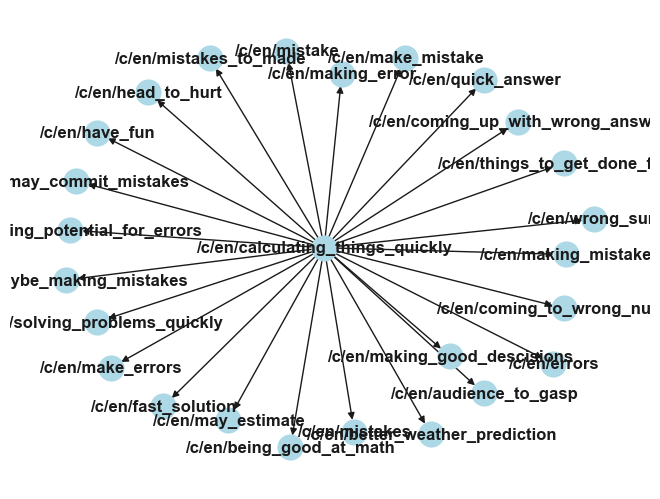

In [117]:
# pos = graphviz_layout(G, prog='dot')
# nx.draw(sub, with_labels=True, arrows=True)
nx.draw(sub, with_labels=True, node_color='lightblue', font_weight='bold');
